# Problem Set 3, due October 1 at 11:59pm.

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import time
from numpy.linalg import inv

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
# Import and load Boston housing data set


data = np.loadtxt('data.txt')
target = np.loadtxt('target.txt')
data


array([[2.18960276e-01, 1.80000000e+01, 2.62928820e+00, ...,
        1.55347112e+01, 3.97462329e+02, 5.71564654e+00],
       [1.41575865e-01, 0.00000000e+00, 7.31561244e+00, ...,
        1.79141306e+01, 3.97012611e+02, 9.33841696e+00],
       [3.80457474e-01, 0.00000000e+00, 7.34035422e+00, ...,
        1.79199892e+01, 3.96628236e+02, 4.14247302e+00],
       ...,
       [2.26098843e-01, 0.00000000e+00, 1.22542013e+01, ...,
        2.10420429e+01, 3.98026747e+02, 5.83116121e+00],
       [1.39833024e-01, 0.00000000e+00, 1.20543793e+01, ...,
        2.11051296e+01, 3.95290366e+02, 6.89084079e+00],
       [1.83073307e-01, 0.00000000e+00, 1.22827881e+01, ...,
        2.13269588e+01, 4.00822740e+02, 8.10644663e+00]])

## Side note: 
You can use the IPython to easily debug your code. Just add the line IPython.embed() as a break point at some place in
your code and it will give you access to a Python terminal where you can view the values that specific variables get, their dimensions etc. The pdb package in Python is also similar to IPython. 

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function (other than sqrt) to compute RMSE.



In [3]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((2,2,3),(0,2,6)))
2.08
"""
def compute_rmse(predictions, yvalues):
  
    # RMSE calculation
    rmse = np.sqrt((np.sum((predictions- yvalues)**2))/len(predictions))
    
    return rmse
print(compute_rmse(np.array([2,2,3]),np.array([0,2,6]))) 

2.0816659994661326


### 1.2 Divide your data into training and testing datasets

Randomly select 80% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 20% in a testing dataset (call this "bdata_test")


In [4]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

# Creating dataframe for dataset with both inputs and target
boston_data = pd.DataFrame(data)

# labelling columns
boston_data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
boston_data['MEDV'] = target
print('boston_data has size, ', boston_data.shape)

## Randomly select 80% of the data for  training dataset, 
bdata_train = boston_data.sample(frac = 0.8,
                            random_state = np.random.seed(seed = 13579))
print( 'bdata_train has ', bdata_train.shape[0],'rows and ', bdata_train.shape[1], 'columns')


# Place the remaining 20% in a testing dataset 
#print((~boston_data.index.isin(bdata_train.index)).sum())
bdata_test = boston_data.loc[~boston_data.index.isin(bdata_train.index)]
print( 'bdata_test has ', bdata_test.shape[0],'rows and ', bdata_test.shape[1], 'columns')

#Sort index for both data sets
bdata_train.sort_index(inplace = True)
bdata_test.sort_index(inplace = True)
# Display both data sets
display(bdata_train.head())
display(bdata_test.head())

boston_data has size,  (506, 14)
bdata_train has  405 rows and  14 columns
bdata_test has  101 rows and  14 columns


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.218960,18.0,2.629288,0.0,0.869420,6.875396,65.2,4.347275,1.0,307.0,15.534711,397.462329,5.715647,24.0
1,0.141576,0.0,7.315612,0.0,0.549711,6.499894,78.9,5.315684,2.0,255.0,17.914131,397.012611,9.338417,21.6
2,0.380457,0.0,7.340354,0.0,0.697928,7.263489,61.1,5.356935,2.0,243.0,17.919989,396.628236,4.142473,34.7
3,0.313563,0.0,2.562407,0.0,0.599629,7.209732,45.8,6.103983,3.0,226.0,18.979527,398.564784,3.239272,33.4
4,0.330105,0.0,2.497337,0.0,0.476077,7.184111,54.2,6.264372,3.0,234.0,18.708888,399.487766,6.115159,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
9,0.512354,12.5,7.904262,0.0,0.743540,6.135438,85.9,6.631109,5.0,319.0,15.526087,389.794672,17.734252,18.9
10,0.471014,12.5,8.105223,0.0,0.696355,6.630284,94.3,6.559948,5.0,318.0,15.329414,394.426261,20.722270,15.0
11,0.378099,12.5,8.037368,0.0,0.733438,6.037591,82.9,6.255507,5.0,320.0,15.208535,398.942967,13.471264,18.9
18,0.912070,0.0,8.166062,0.0,0.546885,5.597011,36.6,4.055867,4.0,315.0,21.232716,290.847821,12.050425,20.2
20,1.540105,0.0,8.476673,0.0,0.778953,5.905249,98.1,3.946739,4.0,311.0,21.224087,380.568759,21.639829,13.6


In [ ]:
# ## Method 2: using np.random.choice
# # Random seed 
# np.random.seed(seed = 13579)

# # Split the data: 80% for training set, remaining 20% testing set
# train_idx = np.random.choice(range(len(boston_data)), int(len(boston_data) * .8), 
#                              replace=False)
# test_idx = list(set(range(len(boston_data))) - set(list(train_idx)))

### 1.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Specifically, do the following:
1. Compute the RMSE of the training set.
2. Now compute the RMSE on the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

Total running Time for RMSE Model: 0.00199s
Run time for test values only: 0.00100s
RMSE training set: 9.207105828882728
RMSE test set: 9.11154006110328
RMSE difference (training - testing): 0.0955657677794477


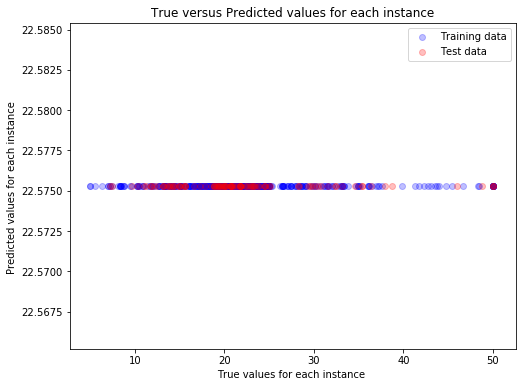

In [6]:

def rmse_model(train_yvals, test_yvals):
    '''
Function
--------
rmse_model

Given training and test target arrays,
calculated the Roote Mean Squared Error and predictions for both sets.
It also provides overall algorithm run time and run time for test data

Parameters
----------
train_yvals : array
    Array of numbers representing the target values of the training set

test_y : array
    Array of numbers  representing the target values of the testing set

Returns
-------
predictions_train : array
    Array of predictions for the training set

rmse_train: float
    Root Mean Squared Error for the training set
    
predictions_test : array
    Array of predictions for the testing set

rmse_test: float
    Root Mean Squared Error for the testing set

 running_time : float
    Total running time of the function

running_time_testonly : float
    Running time for computing the predictions for the testing set

'''
    # Running time measure, start time 
    t_start = time.time()
    # stage 1: create predictions and yvalues for training set
    predictions_train = np.mean(train_yvals) * np.ones(len(train_yvals))
    yvalues_train = train_yvals
    
    # Calculate stage 1 run  time
    t_stage1 = time.time()
    run_time_st1 = t_stage1 - t_start
    
    # stage 2: Compute the RMSE on the training data set 
    rmse_train = compute_rmse(predictions_train, yvalues_train)
    
    # Calculate stage 2 run time
    t_stage2 = time.time()
    run_time_train = t_stage2 -  t_stage1
    
    # stage 3 : create predictions and yvalues for test set
    predictions_test = np.mean(train_yvals) * np.ones(len(test_yvals))
    yvalues_test = test_yvals
    
    # Calculate stage 3 run time
    t_stage3 = time.time()
    run_time_st3 = t_stage3 -  t_stage2
    
    # stage 4: Compute the RMSE on the test data set (but use the model you trained on the training set!).
    rmse_test = compute_rmse(predictions_test, yvalues_test)
    
    # Calculate stage 2 run time
    t_stage4 = time.time()
    run_time_test = t_stage4 -  t_stage3
    
    # Calculate total running time
    t_end = time.time()
    running_time = t_end - t_start
    running_time_testonly = run_time_st3 + run_time_test
    
    return ([predictions_train,rmse_train],
            [predictions_test, rmse_test], 
            running_time, running_time_testonly)

# Get results and print relevant information 
[Training_results, Test_results, Full_run_time, Test_run_time] = rmse_model(bdata_train['MEDV'],  bdata_test['MEDV']) 
print("Total running Time for RMSE Model: {:.5f}s".format(Full_run_time))   
print("Run time for test values only: {:.5f}s".format(Test_run_time))
print("RMSE training set:", Training_results[1])
print("RMSE test set:", Test_results[1])
print("RMSE difference (training - testing):", Training_results[1] - Test_results[1])  


# #  scatter plot that shows the true value of each instance 
# #on the x-axis and the predicted value of each instance on the y-axis. 
def scatter_plot(Training_results, Test_results, ytrain, ytest):
    #create figure
    plt.figure(figsize=(8,6))
    ## plot scatter plots for actual yvalues versus predictions ( Training data)
    plt.scatter(ytrain, Training_results[0],color ='b', label = 'Training data', alpha = 0.25)
    ## plot scatter plots for actual yvalues versus predictions ( Test data)
    plt.scatter(ytest, Test_results[0],color ='r', label = 'Test data', alpha = 0.25)
    
    #set title, labels and legend
    plt.title('True versus Predicted values for each instance')
    plt.xlabel('True values for each instance ')
    plt.ylabel('Predicted values for each instance ')
    plt.legend();
    
# Plot: Call the ScatterPlot function
ytrain = bdata_train['MEDV']
ytest = bdata_test['MEDV']
scatter_plot(Training_results, Test_results, ytrain.values, ytest.values)    




### Observations
#### How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
- RMSE training set: 9.21
- RMSE test set: 9.11
- RMSE difference (training - testing): 0.01
The RMSE values for both the training to test sets are comparable with a diffence of of about 0.1.  This is performance is expected because both groups were created by random sampling and as such on average should be the same. As such if we are using and estimator that relies solely on mean values then we expect the 2 groups test and control should statistically perform simillarly
#### Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?
In order to time the algorithm, the time module is used. We provide the total run time of the algorithm but also the run time for the prediction of test values. The values are show below:

- Total running Time for RMSE Model: 0.00199s
- Run time for test values only: 0.00100s

Overall the run times are very short, on the order of 0.002 seconds, and this is expected because we are ony doing a mean calculations which are relatively easy and fast.

### 1.4 Use local linear regression for prediction, and compute RMSE.

Create a model that predicts, for every observation of nitric oxide concentration the median home value using local linear regression
with Epanechnikov kernels (https://en.wikipedia.org/wiki/Kernel_(statistics)).
1. Create a scatter plot of the test and training data sets (use different colors for the two). Add on that plot the fit
that you get from the local linear regression.
2. Tune the smoothing parameter (the window that Epanechnikov kernels are nonegative) so that the RMSE for the test set is low. 


First create a function that implements the Epanechnikov kernel which you will need to weight the data points.

In [7]:
def epan_ker(target_x, data_x, gamma):
    '''
    Compute the epanechnikov weights. data_x denote the predictors (nitric oxide levels in our case)
    and target denotes the house median value. The gamma parameter controls the smoothing. 
    Inputs: predictors, targets and smoothing parameter gamma 
    Parameters
    ----------
    target_x: numeric value
        Numeric value representing specific point we want to fit
    data_x : array
        Array of numbers representing  associated with nitric oxide levels
    gamma: numeric value
        Numeric value parameter that controls smoothing of kernel
    
    Returns
    -------
    weight: array
        Array of numbers representing the epanechnikov weights associated with each point in the data_x array
        
    Example
    -------    
    >>># Test Function
    >>> data_x = bdata_train['NOX']
    >>> Test = bdata_test['NOX'].values
    >>> target_x = Test[0]
    >>> print(target_x)
    >>> # set gamma parameter 
    >>> gamma = 1
    >>> #compute weights for each target point
    >>> weights = epan_ker(target_x, data_x, gamma)
    >>> weights
    0.7435399971978163
    array([0.73811571, 0.72182281, 0.74843964, 0.7344673 , 0.69634774,
       0.71665001, 0.73815476, 0.74998345, 0.73599839, 0.74994678,
       0.72995834, 0.74992594,......................................
       ...................., 0.74908862, 0.74355992, 0.74882786])
    '''
    
    # create a list of weights
    n = len(data_x)
    weights = []
    ## converting input into values
   
    data_x = data_x.values
    for i in range(0,n):
        #dist = ((target_x-data_x[i])**2)**(1/2)
        dist = np.absolute(target_x-data_x[i])
        ## if outside threshold distance, gamma( change in nitric oxide levels) set weight to zero
        if dist <= gamma: 
            weight = 0.75 * (1 - (dist**2) ) 
            weights.append(weight)
        ## if withing threshold distance, gamme( change in nitric oxide levels) set weight according to 
        ## Epanechnikov kernel
        else:
            #u =  (target_x-data_x[i])/gamma ## normalised distance values
            weight = 0 
            weights.append(weight)
    #pass
    return np.array(weights)
# Test Function
data_x = bdata_train['NOX']
Test = bdata_test['NOX'].values
target_x = Test[0]
print(target_x)
# set gamma parameter 
gamma = 1
#compute weights for each target point
weights = epan_ker(target_x, data_x, gamma)
#weights


0.7435399971978163


In [25]:
# Here you should include the main code for local linear regression

## define local linear regression funtion
def loc_lin_reg(data_x,data_y,target_x,gamma):

    '''
    Model predicts, for every observation of  nitric oxide concentration in the Test set
    the median home value using local linear regression with Epanechnikov kernels 
    Inputs: predictors, targets and smoothing parameter gamma 
    Parameters
    ----------
    data_x: array
        Array of numbers representing  associated with nitric oxide levels for training set
    data_y : array
        Array of numbers representing  associated with median home value  for training set
    target_x: array
        Array of numbers representing  associated with nitric oxide levels for test set
        
    gamma: numeric value
        Numeric value parameter that controls smoothing of kernel
    
    Returns
    -------
    target_y: array
        Array of numbers representing the predicted median home value  for test set
        
    Example
    -------    
    >>> # test function
    >>> # set train data and test data
    >>> data_x = bdata_train['NOX']
    >>> data_y = bdata_train['MEDV']
    >>> target_x = bdata_test['NOX'].values
    >>> # set gamma parameter 
    >>> gamma = 1

    >>> target_y = loc_lin_reg(data_x,data_y,target_x,gamma)
    >>> display(target_y)
    array([28.35362498, 28.66131616, 28.41883177, 29.72504421, 28.1271151 ,
       28.06775652, 29.3596027,............................................
       ............................--------------28.72508388, 29.44346973,
       28.709494])
    '''
    # Running time measure, start time 
    t_start = time.time()
    ## Initialise target_y array
    target_y = np.repeat(0.0,len(target_x))
    for j in range(len(target_x)):
        #compute weights for each target point
        weights = epan_ker(target_x[j], data_x, gamma)
        # convert weights array tp diagonal matrix
        W = np.diag(weights)
        W2 = np.dot(W.T,W)
        #print(W2.shape)
        ## local linear regression
        temp = np.dot(data_x.T,W2)
        #print(temp.shape)
        temp2 =np.dot(data_x.T,np.dot(W2,data_x))
        #print(temp2)
        target_y[j] =(1/temp2)*np.dot(temp,data_y)
    
    # Calculate total running time
    t_end = time.time()
    run_time = t_end - t_start
    print('total run time: ', run_time)   
    return target_y
    
# test function
# set train data and test data
data_x = bdata_train['NOX']
data_y = bdata_train['MEDV']
target_x = bdata_test['NOX'].values
# set gamma parameter 
gamma = 1

target_y = loc_lin_reg(data_x,data_y,target_x,gamma)
#display(targebt_y)





total run time:  0.6313059329986572


total run time:  2.502316474914551
total run time:  0.8656814098358154
----- For gamma = 0.01 ------
RMSE training set: 15.780197166243425
RMSE test set: 15.361980288144329
total run time:  2.893725872039795
total run time:  0.4767279624938965
----- For gamma = 0.05 ------
RMSE training set: 15.319122450043091
RMSE test set: 15.236655132635425
total run time:  2.011619806289673
total run time:  0.49567484855651855
----- For gamma = 0.1 ------
RMSE training set: 14.536422190144599
RMSE test set: 14.557411912816839
total run time:  2.06528639793396
total run time:  0.5166196823120117
----- For gamma = 0.5 ------
RMSE training set: 10.705931370128669
RMSE test set: 10.599011426224104
total run time:  2.295866012573242
total run time:  0.7539806365966797
----- For gamma = 1 ------
RMSE training set: 10.641674414385909
RMSE test set: 10.614749090736934
total run time:  2.064990520477295
total run time:  0.530663013458252
----- For gamma = 2 ------
RMSE training set: 10.641674414385909
RMSE 

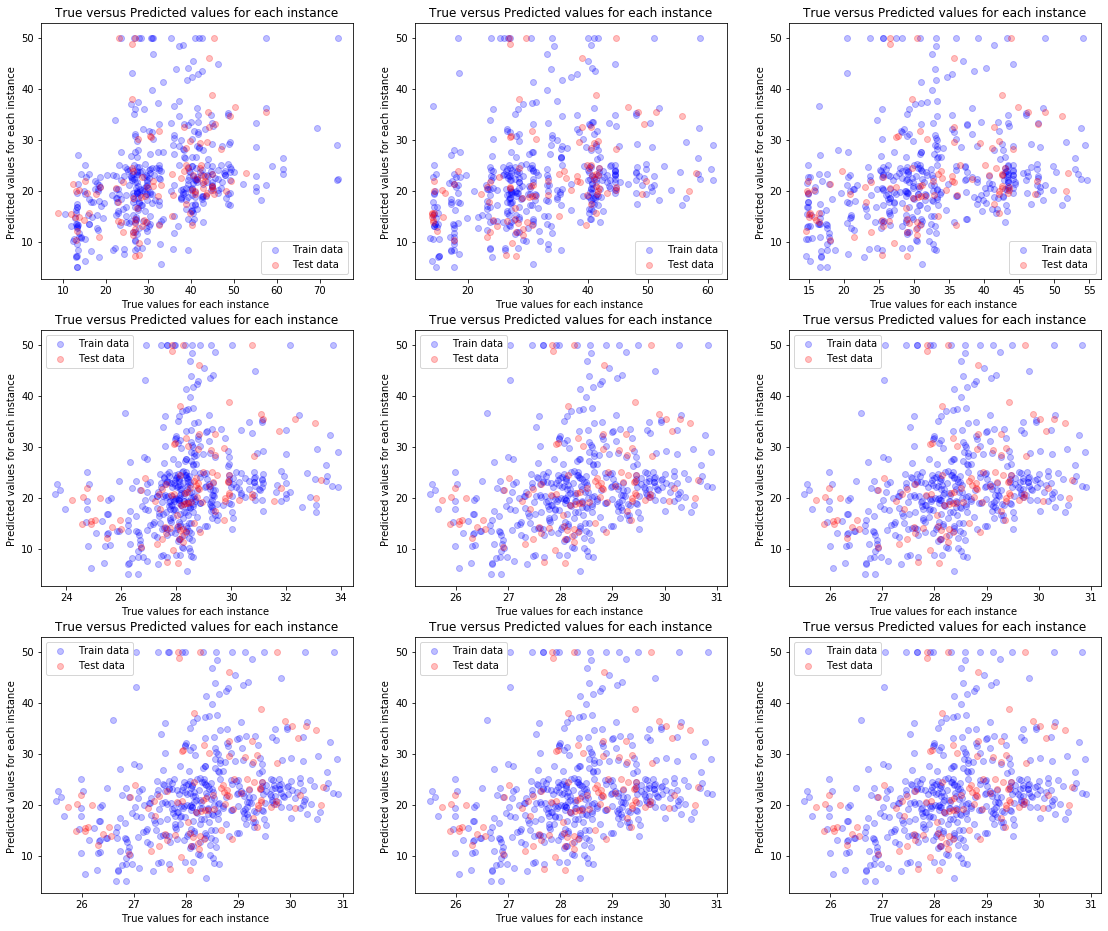

In [26]:
# Tuning gamma value before plotting the final plot
# set train data and test data
data_x = bdata_train['NOX']
data_y = bdata_train['MEDV']
target_x = bdata_test['NOX'].values
# set gamma list  parameter 
gamma_lst = [0.01,0.05,0.1,0.5,1,2,5,10,20]
plt.figure(figsize=(19,16))

## plotting predicted versus actual values
for i in range(len(gamma_lst)):
    predictions_train = loc_lin_reg(data_x,data_y,data_x.values,gamma_lst[i])
    predictions_test = loc_lin_reg(data_x,data_y,target_x,gamma_lst[i])
    rmse_train = compute_rmse(predictions_train,data_y.values)
    rmse_test = compute_rmse(predictions_test,bdata_test['MEDV'].values)

    print( '----- For gamma = {} ------'.format(gamma_lst[i]))
    print("RMSE training set:", rmse_train)
    print("RMSE test set:", rmse_test)
    plt.subplot(3,3,i+1)
    ## plot scatter plots for actual yvalues versus predictions ( Test data)
    plt.scatter(predictions_train,data_y,color ='b', label = 'Train data', alpha = 0.25)
    ## plot scatter plots for actual yvalues versus predictions ( Test data)
    plt.scatter(predictions_test,bdata_test['MEDV'].values,color ='r', label = 'Test data', alpha = 0.25)
    
    #set title, labels and legend
    plt.title('True versus Predicted values for each instance')
    plt.xlabel('True values for each instance ')
    plt.ylabel('Predicted values for each instance ')
    plt.legend();
    
    


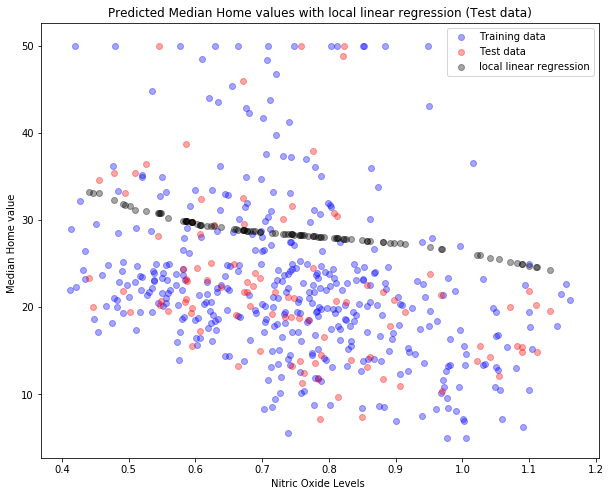

In [21]:
def plot_lowess(x_train, y_train, x_test, y_test, x_plot, y_plot):
    '''
    Scatter plot of data points along with lowess fit.Creates a scatter plot of the test and training data
    sets (use different colors for the two) and adds on that plot the fit that you get from the local linear regression
    Inputs: training and test data points, lowess fitted values
    Parameters
    ----------
    x_train, y_train: array
        Array of numbers representing  associated with nitric oxide levels(data) and 
        Median home values (target) for training set
    
     x_test, y_test: array
        Array of numbers representing  associated with nitric oxide levels(data) and 
        Median home values (target) for test set
        
     x_plot, y_plot: array
        Array of numbers representing  associated with nitric oxide levels(data) and 
        local linear regression predicted Median home values (target) for training set

        
    gamma: numeric value
        Numeric value parameter that controls smoothing of kernel
    
    Returns
    -------
    Figure object
    Example
    -------  
    # set train data and test data
    >>> data_x = bdata_train['NOX']
    >>> data_y = bdata_train['MEDV']
    >>> target_x = bdata_test['NOX'].values
    >>> target_y = bdata_test['MEDV'].values
    >>> gamma = 0.5 ## chosen for tuning values such that gamma created lowest rmse for test set

    >>> ## predictions for test values using local linear regression
    >>> predictions_test = loc_lin_reg(data_x,data_y,target_x,gamma)

    >>> plot_lowess(data_x, data_y, target_x, target_y, target_x, predictions_test) 
    '''

    #create figure
    plt.figure(figsize=(10,8))

    ## plot scatter plots for  Training data
    plt.scatter(x_train, y_train,color ='b', label = 'Training data', alpha = 0.35)
    ## plot scatter plots for actual yvalues versus predictions ( Test data)
    plt.scatter(x_test, y_test,color ='r', label = 'Test data', alpha = 0.35)
    ## plot scatter plots for actual yvalues versus predictions ( Test data)
    plt.scatter(x_plot, y_plot,color ='k', label = 'local linear regression', alpha = 0.35)

    #set title, labels and legend
    plt.title('Predicted Median Home values with local linear regression (Test data)')
    plt.xlabel('Nitric Oxide Levels ')
    plt.ylabel('Median Home value  ')
    plt.legend();
    return
  
## Creates a scatter plot of the test and training data sets (use different colors for the two) 
## and adds on that plot the fit that you get from the local linear regression

# set train data and test data
data_x = bdata_train['NOX']
data_y = bdata_train['MEDV']
target_x = bdata_test['NOX'].values
target_y = bdata_test['MEDV'].values
gamma = 0.5 ## chosen for tuning values such that gamma created lowest rmse for test set

## predictions for test values using local linear regression
predictions_test = loc_lin_reg(data_x,data_y,target_x,gamma)

plot_lowess(data_x, data_y, target_x, target_y, target_x, predictions_test) 

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).
[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [22]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((3,4),(6,8),2))
5

"""
def distance(x1, x2, L):
    #your code here

    # Initialize the difference variable for summation of all differences raised to some power
    diff = 0
    # Summation loop
    for i in range(len(x1)):
        diff += (abs((x1[i] - x2[i]))) ** L
    
    # L norm distance computation
    dist = diff ** (1 / L)
    return dist
# 
print(distance((3,4),(6,8),2))

5.0


### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Make sure to do the following
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

---Test set scenario---
Time taken: 0.18 seconds
RMSE_test:  7.321621310465422
---Train set scenario---
Time taken: 0.77 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.321621310465422


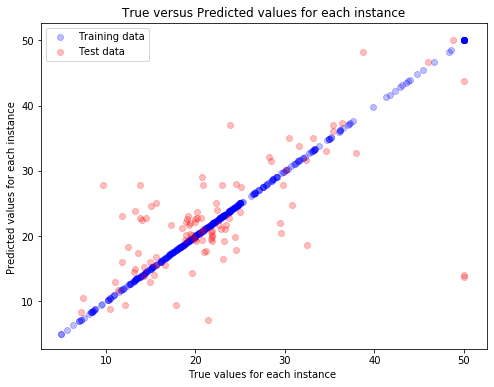

In [23]:
"""
# write your function specification here!

Function
--------
nneighbor

Given two input features('CRIM'and 'RM') and a value for L, return a single output Feature ('MEDV') 

Parameters
----------
train_x : array
    Array of numerical values corresponding to that training data set input features, ('CRIM'and 'RM')
    
train_y : array
    Array of numerical values corresponding to that training data target value, 'MEDV'
    
test_x : array
    Array of numerical values corresponding to that test data set input features, ('CRIM'and 'RM')
    
test_y : array
    Array of numerical values corresponding to that test data target value, 'MEDV'
L: int
    Value of L to use in computing distances

Returns
-------
prediction_test: array
    Array cosnsisting of  the predicted values using the nearest neighbour model

rmse : float
    A floating point value describing the root mean squared error using ouput predictions
    
Example
-------
"""
import time
def nneighbor(train_x, train_y, test_x, test_y, L):
    start_time = time.time()
 
    # Obtain number of Observations
    n_test = len(test_x)
    n_train = len(train_x)
    
    # creat Min Distance and index vectors arragges
    min_dist = np.repeat(1e100, n_test)
    min_idx = np.zeros( n_test)
    
    # Predictor vector
    prediction_test = np.zeros(n_test)
         
    # Transform DF values to numerical inputs
    train_x = train_x.values
    test_x = test_x.values
    
    # Compute distance between all values in Test and Training data
    ## and store min distance  between training and test data and corresponding index 
    for i in range(0, n_test):
        
        for j in range(0, n_train):
            # Calculate the distance 
            dist = distance(train_x[j], test_x[i], L)
            #print(dist)
            # If we find smaller distance value between i and all j's, update current solution
            if dist < min_dist[i]:
                min_dist[i] = dist ## update min_dist value
                min_idx[i] = j  #update min_dist index value
                prediction_test[i] = train_y.values[j]
    #print(min_dist)
    #Computing  RMSE value
    rmse = compute_rmse(prediction_test, test_y)
    
    # Compute running time
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    
    # Return Root mean squared error and predictor 
    return [prediction_test, rmse] 

  

#Set values for inputs
L = 2
#training values 
train_x = bdata_train[['CRIM', 'RM']]
train_y = bdata_train['MEDV']
# test values
test_x = bdata_test[['CRIM', 'RM']]
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



### Observations
##### Part 5:  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
Below, I record estimate of total run time of the whole algorith and also estimate of run time for test and training set scnarios:

Using the Test data, 
- Time taken: 0.18 seconds
- RMSE_test:  7.321621310465422

Using the training data scenario
- Time taken: 0.77 seconds
- RMSE_training:  0.0



##### Part 6: How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?
Additionally I provide the difference in RMSE values between test and training
- RMSE_train = 0.0
- RMSE_test = 7.32
- RMSE difference (train_set - test_set): -7.32
We notice that ths model differs from 1.4 firstly because there is a zero training error for the training set. This is expected because we have stored all the training data and as such we will always match elements we have seen in our tarinings et perfectly.Additionally there is a clear difference between the RMSE values for the training set in the nearest neighbour results. This is because in this case most of the test set are new examples that we have never seen so we are expected to perform worse.

More so, we can observe that the $RMSE_{test}$ value has decreased in comparison to the predictive model in part 1.4, from $10.599$ to $7.71$ demonstrating that the current Nearest Neighbor model is more accurate in its predictions than the local linear regression model.

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

*NOTE 2*: In this case, there might not be a major impact on RMSE; don't get confused if you find that to be the case.

In [24]:
"""
Function
--------
normalize

Given an array of values for a given feature as input, and returns the normalized array
(subtract the mean and divide by the standard deviation).

Parameters
----------
raw_data: array
    Array of numerical values corresponding to generic array of any given feature

Returns
-------
normalized_data: array
    Array of numerical values corresponding to normalized array (subtract the mean and divide by the standard deviation)
    of the given input array


Example
-------
# Testing the function
>>> test = np.array([21, 7, 93, 36])
>>> normalized_test = normalize(test)
>>> normalized_test
array([-0.55839192, -0.98674736,  1.64457893, -0.09943966])
"""
def normalize(raw_data):
    #cclculate mean and standard deviation
    mean = np.mean(raw_data)
    std = np.std(raw_data)
    #normalise array by subtracting mean and diving by standard dev
    normalized_data = (raw_data- mean)/std
    return normalized_data

# Testing the function
test = np.array([21, 7, 93, 36])
normalized_test = normalize(test)
normalized_test

array([-0.55839192, -0.98674736,  1.64457893, -0.09943966])

---Test set scenario---
Time taken: 0.33 seconds
RMSE_test:  7.575494624899498
---Train set scenario---
Time taken: 0.80 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.575494624899498


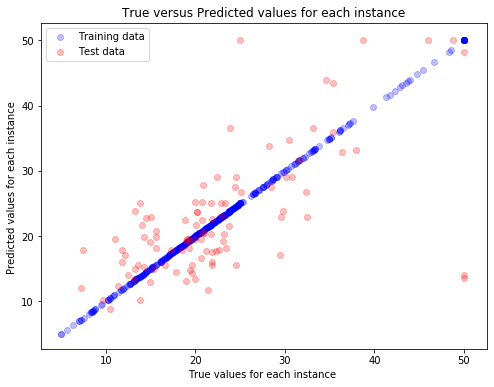

In [46]:
#Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input)
# Model 0: Set values for inputs
L = 2
#normalize test and training data
train_x = normalize(bdata_train[['CRIM', 'RM']])
test_x = normalize(bdata_test[['CRIM', 'RM']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



### Observations
#### Compare the RMSE from this method with your previous RMSE evaluations. What do you observe?
comparing the normalised versus default version, we obtain the following:

| Model                         |# Features |	Features |	L-value |	RMSE (test) |Running Time [s] | 
|-------------------------------|-----------|------------|----------|---------------|-----------------|
|   Mean Model                  |     -     |      -     |          |     9.11      |       0.001     |
|  Local Lin Reg                |     -     |      -     |    -     |    10.60      |       0.754     |
|  Nearest Neighbor             |     2     |  CRIM, RM  |    2     |     7.32      |       0.18      |
|  Nearest Neighbor(normalized) |     2     |  CRIM, RM  |    2     |     7.58      |       0.33      |

We notice that are pretty similar as expected but there is a slight increase in RMSE value for the test function which is contrary to intuition. However, we  hypothesize may due to how the data was randomly sampled. Future tests could involve using different random samples to test how the relative rmse values change between default and namrmalized versions

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features

---Test set scenario---
Time taken: 0.19 seconds
RMSE_test:  9.552890807094848
---Train set scenario---
Time taken: 0.78 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -9.552890807094848


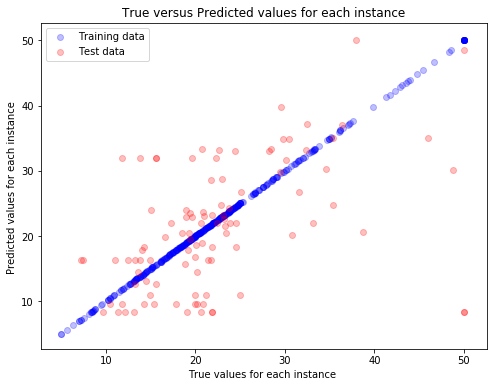

In [27]:
# Model 1: 2 different features ('TAX','PTRATIO'), normalized 
#Set values for inputs
L = 2
#normalize test and training data
train_x = normalize(bdata_train[['TAX','PTRATIO']])
test_x = normalize(bdata_test[['TAX','PTRATIO']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.37 seconds
RMSE_test:  7.228957171140122
---Train set scenario---
Time taken: 1.51 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.228957171140122


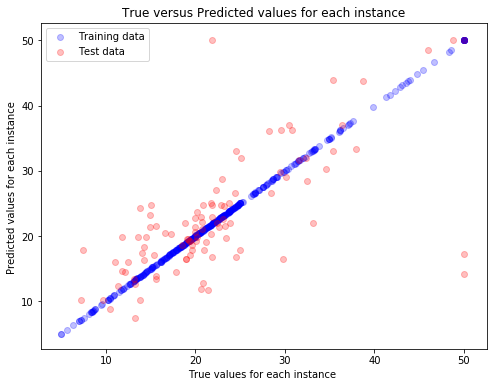

In [28]:
# Model 2: More than 4 features (6)
#Set values for inputs
L = 2
#normalize test and training data
train_x = normalize(bdata_train[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])
test_x = normalize(bdata_test[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.67 seconds
RMSE_test:  7.263437530018087
---Train set scenario---
Time taken: 2.46 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.263437530018087


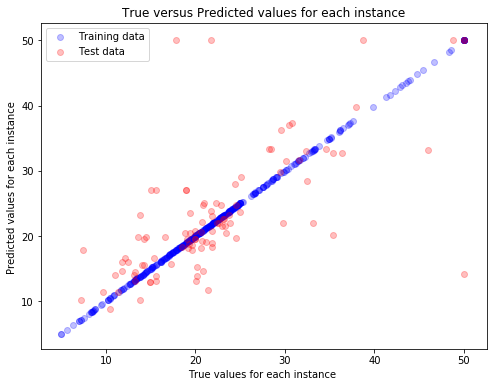

In [29]:
# Model 3: More than 4 features (9)
#Set values for inputs
L = 2
#normalize test and training data
train_x = normalize(bdata_train[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS','ZN', 'CHAS', 'NOX']])
test_x = normalize(bdata_test[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS','ZN', 'CHAS', 'NOX']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.20 seconds
RMSE_test:  7.519947071648579
---Train set scenario---
Time taken: 0.68 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.519947071648579


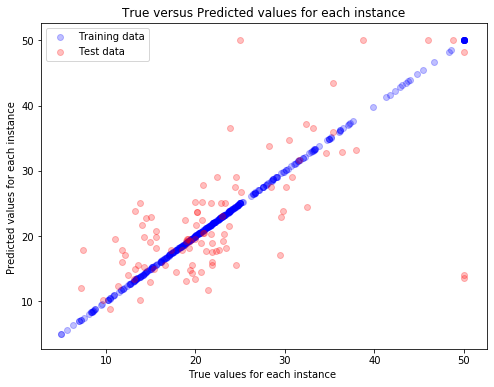

In [34]:
#Model 4: using a different value of =5
#Set values for inputs
L = 5
#normalize test and training data
train_x = normalize(bdata_train[['CRIM', 'RM']])
test_x = normalize(bdata_test[['CRIM', 'RM']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.20 seconds
RMSE_test:  7.55658522072105
---Train set scenario---
Time taken: 0.95 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.55658522072105


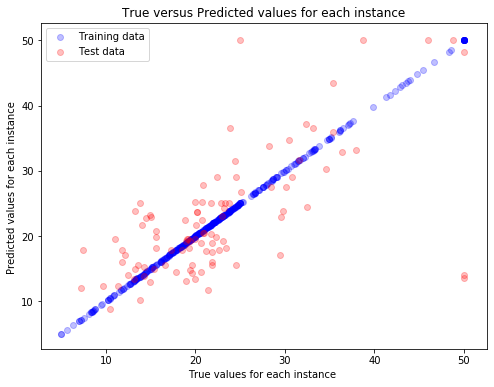

In [35]:
#Model 5: using a different value of =10 for the same 2 features
#Set values for inputs
L = 10
#normalize test and training data
train_x = normalize(bdata_train[['CRIM', 'RM']])
test_x = normalize(bdata_test[['CRIM', 'RM']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.41 seconds
RMSE_test:  7.167141744941229
---Train set scenario---
Time taken: 1.57 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.167141744941229


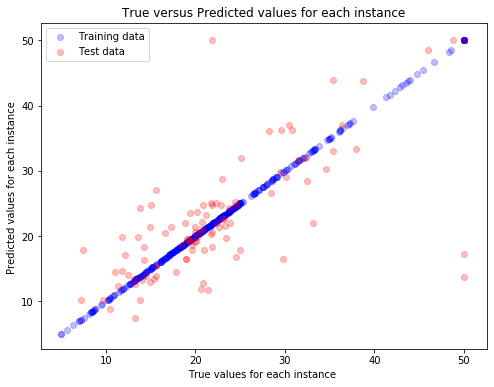

In [36]:
#Model 6: combines 6 features and using a different value of =1
#Set values for inputs
L = 1
#training values 
train_x = normalize(bdata_train[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])
train_y = bdata_train['MEDV']
# test values
test_x = normalize(bdata_test[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



---Test set scenario---
Time taken: 0.41 seconds
RMSE_test:  7.011765218912318
---Train set scenario---
Time taken: 1.49 seconds
RMSE_training:  0.0
RMSE difference (train_set - test_set): -7.011765218912318


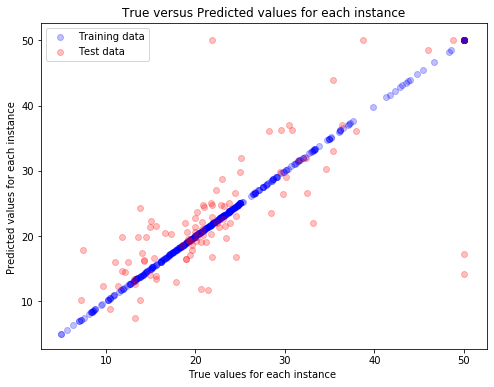

In [37]:
#Model 7: combines 6 features and using a different value of =100
#Set values for inputs
L = 100
#training values 
train_x = normalize(bdata_train[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])
train_y = bdata_train['MEDV']
# test values
test_x = normalize(bdata_test[['CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS']])
test_y = bdata_test['MEDV']

#Part 2: Predict the median home value of every instance in the test set. Report the RMSE_test 
print('---Test set scenario---')
test_results = nneighbor(train_x, train_y, test_x, test_y, L)
print('RMSE_test: ',test_results[1] )
#nneighbor(train_x, train_y, test_x, test_y, L)
#Part 3: Predict the median home value of every instance in the training set. Report the RMSE_training
print('---Train set scenario---')
train_results = nneighbor(train_x, train_y, train_x, train_y, L)
print('RMSE_training: ',train_results[1] )
#Part 3: Print Comparison
print("RMSE difference (train_set - test_set):", 
      train_results[1] - test_results[1])

# Part 4: Create a scatter plot that shows the true value of each instance on the x-axis and the predicted
# value of each instance on the y-axis. Color the training instances in blue and the test instances in red.
scatter_plot(train_results, test_results, train_y.values, test_y.values) ## call previously defined function



### Observations

#### What combination of features and distance function provide the lowest RMSE? Do your decisions affect the running time of the algorithm?

For the optimization we try 8 different combinations of hyperparameters including the default case. The different models were selected to test various changes to hyperparameters, seperately and in combination.  A summary table of the 8 different models is presented below:

| Model   |# Features |	Features                                                         |L-value|RMSE(test)|Running Time [s] | 
|---------|-----------|------------------------------------------------------------------|-------|----------|-----------------|
| Model 0 |     2     | 'CRIM', 'RM'                                                     |    2  |   7.57   |       0.33      | 
| Model 1 |     2     | 'TAX','PTRATIO'                                                  |    2  |   9.55   |       0.19      |
| Model 2 |     6     | 'CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS'                     |    2  |   7.23   |       0.37      |
| Model 3 |     9     | 'CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS','ZN', 'CHAS', 'NOX' |    2  |   7.26   |       0.67      |
| Model 4 |     2     | 'CRIM', 'RM'                                                     |    5  |   7.51   |       0.20      |
| Model 5 |     2     | 'CRIM', 'RM'                                                     |   10  |   7.56   |       0.20      |
| Model 6 |     6     | 'CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS'                     |    1  |   7.16   |       0.41      |
| Model 7 |     6     | 'CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS'                     |  100  |   7.01   |       0.41      |

Model 0 vs Model1: tests how changes in combination of variables selected can affect RMSE. we Notice that when we use 'TAX','PTRATIO' features to predict target as in model 1, our RMSE values are much higher than when we use our default featuresfrom model 0, 'CRIM', 'RM'. This tells us that some variables have stronger correlations with the target and may be able to capture more of the information needed than other. In this case our default deatures , 'CRIM', 'RM' are superior to the 
'TAX','PTRATIO' features  when using only 2 features to predict target. 
Model 0 vs 2 vs  3: explore the effect of increasing the number of features that we use for prediction. We notice that using a combination of 6 features seem to provide the lowest error . 

Model 0 vs 4 vs 5: Combination models
We note that using 2 features, changing the L-value alone does not seem to have any significant effect on the RMSE value. 

Model 6 vs 7: Combination models
However, as the number of features increases, as in model 6 and 7 we notice chaning the value of L has a marked impact on the RMSE values. Also we see that six features seems to be the right number of features that offers lowest error. 

Based on the above table, we see that a combination of 6 features ('CRIM', 'RM', 'DIS','TAX','PTRATIO', 'INDUS') using an L-value of 100 produces the lowest RMSE and we notice that the running time only increase by 0.1 seconds for an .5 inprovement in RMSE from the default case. Of course, we could carry out this optimization analysis at a finer resolution to obtain more accurately tuned parameters but this will require even more models to be created by combining dirrent values of hyperpparamters and may be very computationally intensive.


### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations. What do you observe?
[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [45]:
# Create Cross Validation, CV function
"""
Function
--------
k_fold_crossval

Given a number of folds (int) and pertinent tuning parameters for the model, return the Root Mean Squared Error associated
with the test set

Parameters
----------
k : int 
    Number of folds to be used in CV algorithm
    default value set to 10

data : DataFrame
    Dataframe  with all the relevant features and target values
    
target_name : String
    String representing the name of the target value inside the DataFrame

verbose : Boolean
    Boolean flag printing summary info for debugging
    default set to False

hyper_params : array
    Array of tuning parameters for the model under study

model: object
    Model object returning the RMSE and predictions for the test set

Returns
-------
rmse: float
    Average Root Mean Squared Error obtained by the k-fold CV algorithm

Example 
-------
>>> # Test Function
>>> # Define the target variable name
>>> target_name = "MEDV"

>>> #normalize test and training data
>>> data = normalize(boston_data[['CRIM', 'RM']])
>>> data[target_name] = boston_data[target_name]

>>> # Call the CV  function 

>>> L = 2
>>> Result = k_fold_crossval(data, target_name, [L], nneighbor)

>>> # Print results
>>> print("Average K-fold CV RMSE:", Result)


------------ CV Iteration: 1 ------------
Time taken: 0.13 seconds
RMSE testing set: 5.971402436515524

------------ CV Iteration: 2 ------------
Time taken: 0.09 seconds
RMSE testing set: 9.143914723497165

------------ CV Iteration: 3 ------------
Time taken: 0.11 seconds
RMSE testing set: 7.070416134410017

------------ CV Iteration: 4 ------------
Time taken: 0.20 seconds
RMSE testing set: 6.235744526832508

------------ CV Iteration: 5 ------------
Time taken: 0.10 seconds
RMSE testing set: 8.160509884108189

------------ CV Iteration: 6 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.319516416175515

------------ CV Iteration: 7 ------------
Time taken: 0.12 seconds
RMSE testing set: 9.87196029165434

------------ CV Iteration: 8 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.419575629142932

------------ CV Iteration: 9 ------------
Time taken: 0.10 seconds
RMSE testing set: 6.323132135263346

------------ CV Iteration: 10 ------------
Time taken: 0.10 seconds
RMSE testing set: 9.398702038047595
Total run time: 1.18 seconds

Average K-fold CV RMSE: 7.29
"""

# K-fold Cross-validation function
def k_fold_crossval(data, target_name, hyper_params, model,k=10,verbose = False):
    
    # Set Random seed 
    np.random.seed(seed = 13579)
    
    # Randomly split data into k equally-size sets
    k_idx = np.random.permutation(data.shape[0])
    k_sets = np.array_split(data.iloc[k_idx], k)
        
    # Initialize array for rmses
    rmse_array = np.repeat(0.0, k)
        
    # Start timer at the begining of main CV iteration loop
    starting_time = time.time()
    for ii in range(0, k):
        print("\n------------ CV Iteration:", ii + 1, "------------")
        
        # Select the training and testing sets for every iteration
        validation_set = k_sets[ii]
        training_sets = [k_sets[s] for s in range(0, len(k_sets)) if s != ii] 
     
        # Verbose information
        if (verbose == True):
            print("Number of training sets:", len(training_sets))
            print("Number of validation sets:", len(k_sets) - len(training_sets))
            print("Dimensions of validation set:", validation_set.shape)
        
        # Merge the current training sets
        training_data = pd.concat(training_sets)
        if (verbose == True):
            print("Dimensions of combined training set:", training_data.shape)
        
        # Set relevant  features and target values for training and validation set
        train_y = training_data[target_name]
        test_y = validation_set[target_name]
        norm_train_x = training_data.drop(target_name, axis = 1)
        norm_test_x = validation_set.drop(target_name, axis = 1)

        # Call selected model and use flag for passing any number of hyper paramters in model function      
        results = model(norm_train_x, train_y, norm_test_x, test_y, *hyper_params)
        
        # Display the RMSE
        print("RMSE testing set:", results[1])
        rmse_array[ii] = results[1]

    # Compute the average rmse
    rmse = np.round(np.mean(rmse_array), decimals = 2)
      
    # Total running time
    print("Total run time: {:.2f} seconds".format(time.time() - starting_time))
    
    # Return the avg rmse
    return rmse

# Test Function
# Define the target variable name
target_name = "MEDV"

#normalize test and training data
data = normalize(boston_data[['CRIM', 'RM']])
data[target_name] = boston_data[target_name]

# Call the CV  function 

L = 2
Result = k_fold_crossval(data, target_name, [L], nneighbor)

# Print results
print("Average K-fold CV RMSE:", Result)


------------ CV Iteration: 1 ------------
Time taken: 0.13 seconds
RMSE testing set: 5.971402436515524

------------ CV Iteration: 2 ------------
Time taken: 0.09 seconds
RMSE testing set: 9.143914723497165

------------ CV Iteration: 3 ------------
Time taken: 0.11 seconds
RMSE testing set: 7.070416134410017

------------ CV Iteration: 4 ------------
Time taken: 0.20 seconds
RMSE testing set: 6.235744526832508

------------ CV Iteration: 5 ------------
Time taken: 0.10 seconds
RMSE testing set: 8.160509884108189

------------ CV Iteration: 6 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.319516416175515

------------ CV Iteration: 7 ------------
Time taken: 0.12 seconds
RMSE testing set: 9.87196029165434

------------ CV Iteration: 8 ------------
Time taken: 0.10 seconds
RMSE testing set: 5.419575629142932

------------ CV Iteration: 9 ------------
Time taken: 0.10 seconds
RMSE testing set: 6.323132135263346

------------ CV Iteration: 10 ------------
Time taken: 0.10 seco

### Observations:
####  Report the average RMSE across the 10 iterations. What do you observe?
From the implemented 10 fold cross validation, we obtain a mean rmse value as follows:
- Average K-fold CV RMSE: 7.29
We notice that the RMSE values vary significantly between different folds.

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

In [62]:

"""
# write your function specification here!

Function
--------
Knn

Given two input features('CRIM'and 'RM') and a value for L, return a single output Feature ('MEDV') 

Parameters
----------
train_x : array
    Array of numerical values corresponding to that training data set input features, ('CRIM'and 'RM')
    
train_y : array
    Array of numerical values corresponding to that training data target value, 'MEDV'
    
test_x : array
    Array of numerical values corresponding to that test data set input features, ('CRIM'and 'RM')
    
test_y : array
    Array of numerical values corresponding to that test data target value, 'MEDV'
L: int
    Value of L to use in computing distances
K: int
    Number of neighbors considered 
Returns
-------
prediction_test: array
    Array cosnsisting of  the predicted values using the nearest neighbour model

rmse : float
    A floating point value describing the root mean squared error using ouput predictions
    
Example
-------
>>> # Test Knn Function with normalized data
>>> # Step 0: L and K values, and normalize data
>>> K = 1
>>> L = 2
>>> #normalize test and training data
>>> norm_train_x = normalize(bdata_train[['CRIM', 'RM']])
>>> norm_test_x = normalize(bdata_test[['CRIM', 'RM']])

>>> # Assign train_y and test_y
>>> train_y = bdata_train['MEDV']
>>> test_y = bdata_test['MEDV']

>>> # call Knn function and print RMSE value
>>> TestResults = knn(norm_train_x, train_y, norm_test_x, test_y, L, K)
>>> print("RMSE testing set:", TestResults[1])

Time taken: 0.24 seconds
RMSE testing set: 7.575494624899498
"""
def knn(train_x, train_y, test_x, test_y ,L, K):
    #start timer
    start_time = time.time()
 
    # Obtain number of Observations
    n_test = len(test_x)
    n_train = len(train_x)
    
    # creat Min Distance and index vectors arragges
    min_dist = np.repeat(1e100, n_test)
    min_idx = np.zeros( n_test)
    
    # Predictor vector
    prediction_test = np.zeros(n_test)
         
    # Transform DF values to numerical inputs
    train_x = train_x.values
    test_x = test_x.values
    
     # initialise distance list  and  and k_neighbors arrays
    dists = [0 for i in range(0, len(train_x))]
    k_neighbors = np.repeat(0.0, K)
    
    # Compute distance between all values in Test and Training data
    ## and store  distance  between training and test data and corresponding index 
      
    for i in range(0, n_test):
        for j in range(0, n_train):
            # Calculate the distance and store it inside Distance array
            dist = distance(train_x[j], test_x[i], L)
            dists[j] = [j, dist]
        
        # Sort Distance array by distances, second column of array
        dists = sorted(dists, key=lambda row: row[1])
               
        # Save the K-NN
        for n in range(0, K):
            k_neighbors[n] = train_y.values[dists[n][0]]
                
        # Compute the mean of the K-NN
        prediction_test[i] = np.mean(k_neighbors)   
            
    #Computing  RMSE value
    rmse = compute_rmse(prediction_test, test_y)
    
    # Compute running time
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    
    # Return Root mean squared error and predictor 
    return [prediction_test, rmse] 

# Test Knn Function with normalized data
# Step 0: L and K values, and normalize data
K = 1
L = 2


#normalize test and training data
norm_train_x = normalize(bdata_train[['CRIM', 'RM']])
norm_test_x = normalize(bdata_test[['CRIM', 'RM']])

# Assign train_y and test_y
train_y = bdata_train['MEDV']
test_y = bdata_test['MEDV']

# call Knn function and print RMSE value
TestResults = knn(norm_train_x, train_y, norm_test_x, test_y, L, K)
print("RMSE testing set:", TestResults[1])

Time taken: 0.24 seconds
RMSE testing set: 7.575494624899498


In [63]:
# Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

# Define the target variable name
target_name = "MEDV"

#normalize test and training data
data = normalize(boston_data[['CRIM', 'RM']])
data[target_name] = boston_data[target_name]

# Call the CV  function 
K= 3
L = 2
Result = k_fold_crossval(data, target_name, [L,K], knn)

# Print results
print("Average K-fold CV RMSE for knn :", Result)


------------ CV Iteration: 1 ------------
Time taken: 0.14 seconds
RMSE testing set: 4.748610621249547

------------ CV Iteration: 2 ------------
Time taken: 0.11 seconds
RMSE testing set: 5.668198562641729

------------ CV Iteration: 3 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.943275179363443

------------ CV Iteration: 4 ------------
Time taken: 0.10 seconds
RMSE testing set: 6.1103095136777785

------------ CV Iteration: 5 ------------
Time taken: 0.11 seconds
RMSE testing set: 6.342647090394497

------------ CV Iteration: 6 ------------
Time taken: 0.10 seconds
RMSE testing set: 4.635608601078883

------------ CV Iteration: 7 ------------
Time taken: 0.13 seconds
RMSE testing set: 8.414517877520442

------------ CV Iteration: 8 ------------
Time taken: 0.17 seconds
RMSE testing set: 4.256939432659729

------------ CV Iteration: 9 ------------
Time taken: 0.21 seconds
RMSE testing set: 4.284908919037188

------------ CV Iteration: 10 ------------
Time taken: 0.17 se

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [76]:
# Define the target variable name
target_name= "MEDV"

#normalize test and training data including relevat features 
data = normalize(boston_data[["CRIM", "ZN", "RM", "AGE", "DIS", "TAX"]])
data[target_name] = boston_data[target_name]

# Call the CV  function 
k_list = [i for i in range(1,26)]
L = 2

#  array storing average rmse list
rmse_avg= np.repeat(0.0,len(k_list))

# k-fold CV iterations
# Starting time
start = time.time()
for ii in k_list:

    Result = k_fold_crossval(data, target_name, [L, k_list[ii-1]], knn)

    # Save the AVG RMSE from the current iteration
    rmse_avg[ii-1] =  Result
    print("\nAverage K-fold CV RMSE:", Result)
    
# Total running time
print("\nTotal running time: {:.2f} seconds".format(time.time() - start))




------------ CV Iteration: 1 ------------
Time taken: 0.31 seconds
RMSE testing set: 3.979481688587588

------------ CV Iteration: 2 ------------
Time taken: 0.32 seconds
RMSE testing set: 4.69952020913608

------------ CV Iteration: 3 ------------
Time taken: 0.26 seconds
RMSE testing set: 6.825054765276218

------------ CV Iteration: 4 ------------
Time taken: 0.27 seconds
RMSE testing set: 5.582184546727697

------------ CV Iteration: 5 ------------
Time taken: 0.32 seconds
RMSE testing set: 5.658101947390028

------------ CV Iteration: 6 ------------
Time taken: 0.34 seconds
RMSE testing set: 4.516310310810077

------------ CV Iteration: 7 ------------
Time taken: 0.30 seconds
RMSE testing set: 9.044302073681528

------------ CV Iteration: 8 ------------
Time taken: 0.29 seconds
RMSE testing set: 4.568084937914356

------------ CV Iteration: 9 ------------
Time taken: 0.26 seconds
RMSE testing set: 5.776971524942805

------------ CV Iteration: 10 ------------
Time taken: 0.28 seco

Time taken: 0.21 seconds
RMSE testing set: 3.30434391755613

------------ CV Iteration: 7 ------------
Time taken: 0.21 seconds
RMSE testing set: 9.161008575751907

------------ CV Iteration: 8 ------------
Time taken: 0.21 seconds
RMSE testing set: 3.443685344220636

------------ CV Iteration: 9 ------------
Time taken: 0.21 seconds
RMSE testing set: 3.917357208629308

------------ CV Iteration: 10 ------------
Time taken: 0.34 seconds
RMSE testing set: 8.189252293402616
Total run time: 2.47 seconds

Average K-fold CV RMSE: 4.99

------------ CV Iteration: 1 ------------
Time taken: 0.24 seconds
RMSE testing set: 3.9263391281710405

------------ CV Iteration: 2 ------------
Time taken: 0.21 seconds
RMSE testing set: 3.8139899059466313

------------ CV Iteration: 3 ------------
Time taken: 0.21 seconds
RMSE testing set: 4.0655798754959624

------------ CV Iteration: 4 ------------
Time taken: 0.22 seconds
RMSE testing set: 6.157648708558337

------------ CV Iteration: 5 ------------
Ti

Time taken: 0.22 seconds
RMSE testing set: 4.41022157959523

------------ CV Iteration: 2 ------------
Time taken: 0.21 seconds
RMSE testing set: 4.14297563225525

------------ CV Iteration: 3 ------------
Time taken: 0.23 seconds
RMSE testing set: 4.008804552475835

------------ CV Iteration: 4 ------------
Time taken: 0.19 seconds
RMSE testing set: 6.3407508847997045

------------ CV Iteration: 5 ------------
Time taken: 0.23 seconds
RMSE testing set: 4.715098249371428

------------ CV Iteration: 6 ------------
Time taken: 0.21 seconds
RMSE testing set: 3.623385691093562

------------ CV Iteration: 7 ------------
Time taken: 0.22 seconds
RMSE testing set: 9.439142034303224

------------ CV Iteration: 8 ------------
Time taken: 0.19 seconds
RMSE testing set: 3.728602494568172

------------ CV Iteration: 9 ------------
Time taken: 0.21 seconds
RMSE testing set: 4.259363307027237

------------ CV Iteration: 10 ------------
Time taken: 0.20 seconds
RMSE testing set: 8.238659535233872
Tot

Time taken: 0.25 seconds
RMSE testing set: 3.856784548895566

------------ CV Iteration: 7 ------------
Time taken: 0.24 seconds
RMSE testing set: 9.563881250552477

------------ CV Iteration: 8 ------------
Time taken: 0.23 seconds
RMSE testing set: 4.230713963708976

------------ CV Iteration: 9 ------------
Time taken: 0.27 seconds
RMSE testing set: 4.406447673172611

------------ CV Iteration: 10 ------------
Time taken: 0.32 seconds
RMSE testing set: 8.163194035547837
Total run time: 2.92 seconds

Average K-fold CV RMSE: 5.38

------------ CV Iteration: 1 ------------
Time taken: 0.32 seconds
RMSE testing set: 4.783463922404964

------------ CV Iteration: 2 ------------
Time taken: 0.23 seconds
RMSE testing set: 4.210685697940533

------------ CV Iteration: 3 ------------
Time taken: 0.30 seconds
RMSE testing set: 4.098453606362725

------------ CV Iteration: 4 ------------
Time taken: 0.24 seconds
RMSE testing set: 6.201543118503135

------------ CV Iteration: 5 ------------
Time


AVG RMSE array: [5.9  5.39 5.14 5.08 4.96 4.89 4.96 4.99 5.04 5.14 5.17 5.17 5.21 5.22
 5.25 5.29 5.29 5.29 5.31 5.3  5.36 5.38 5.38 5.41 5.45]
Best K value:  6


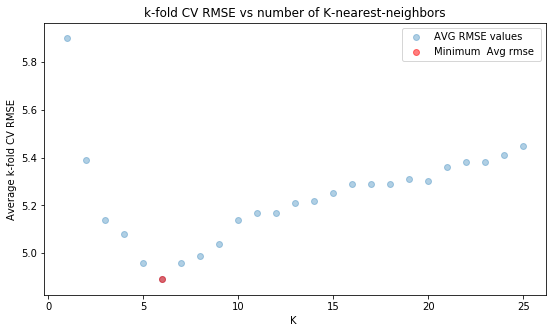

In [82]:
# Printout the RMSEs values for checking purposes
print("\nAVG RMSE array:", rmse_avg)
min_rmse = np.min(rmse_avg)

K_min_rmse =np.where(rmse_avg== min_rmse)[0][0]+1
print('Best K value: ',K_min_rmse )
# Plot
# Scatter plot k-fold CV RMSE vs number of Nearest-Neighbors
# Figure size
plt.figure(figsize = (9, 5)) 

# Title and labels
plt.title('k-fold CV RMSE vs number of K-nearest-neighbors')
plt.xlabel('K ')
plt.ylabel('Average k-fold CV RMSE')

# Plot
plt.scatter(k_list, rmse_avg, alpha = 0.35, label = 'AVG RMSE values')
plt.scatter(K_min_rmse, min_rmse, alpha = 0.5, label = 'Minimum  Avg rmse ',color = "red")
plt.legend()

### Observations:
#### Create a graph that shows how RMSE changes as K increases from 1 to 25. Label your axes, and summarize what you see. What do you think is a reasonable choice of K for this model?
From the plot above, we notice a somewhat v-shape, where for increasing number,K  of nearest neighbors, the average rmse values accross 10-folds decreases and then begins to increase after K=6. This plot indicates the existence of some optimal value that can be found at the botton of the v shape. 

In order to select the best choice for K, we set the criteria that we want to select the K that has the lowest average rmse value accross all ten folds. From our plot, we notice that this happens when K=6, which is the point plotted in red. This selection criteria is reasonable, however, we could additionally calculate confidence intevals, CI around the average values. The extension is relevant as using more nearest neighbors means longer computation time. Depending on the size of these CI, we may realise that using slightly less nearest neighbors may give very similar accuracy.

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

In [ ]:
## Implementing Forward Selection, FS Algorithm
# Define the target variable name
target_name= "MEDV"
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']
#normalize test and training data including relevat features 
data = normalize(boston_data.drop(target_name, axis = 1))
data[target_name] = boston_data[target_name]

# Maximum number of iterations for FF algorithm: total number of features
MaxOuterIters = len(Features)

# Auxiliary variables for recording Features selected for each iteration
IterFeatures = [None for i in range(0, MaxOuterIters)]
CurrentFeatures = []

# RMSE array for keeping each AVG RMSE value
OuterIterRMSE = np.repeat(1.0e10, MaxOuterIters)

# Set relevant parameters: K (NN), k (folds) defaults to 10, and L (norm)
K = 6
L = 2

# Starting time
startff = time.time()


# FS algorithm 
for n in range(1, len(features) + 1):
    print("\n------------------------","Iteration", n, "------------------------")
    print("List of features in use:", [f for f in IterFeatures if f != None])
    
    # Iteration initial status summary
    if (n == 1):
        print("Best RMSE value: None")
    else:
        print("Best RMSE value:", OuterIterRMSE[n-1])
    
    for i in Features:
        # Features to be included in the model
        # if iteration 1: test isolated features
        if (n == 1):
            TotestFeat = [i]

        # else, include the previously selected features plus the one being tested
        else:
            TotestFeat = [f for f in IterFeatures if f != None]
            if (IterFeatures[n] != None):
                TotestFeat.remove(IterFeatures[n])
            TotestFeat.append(i)
            
        # Print out the features to be included in the current model
        print("\nRunning model with features:", TotestFeat)

        # Include dataTargetName
        TotestFeat.append(dataTargetName)

        # Call the CV function with K-nn function
        Result = KfoldCrossVal(k, normboston[TotestFeat], dataTargetName, 
                               verbose, [L, K], knn)
